In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import prophet
from prophet import Prophet
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_percentage_error


# Loading the data
- It works best with time series that have strong seasonal effects and several seasons of historical data.
- It is robust to missing data and shifts in the trend, and typically handles outliers well.
- It handles unevenly distributed time intervals.
- Prophet’s default settings to produce forecasts that are often accurate as those produced by skilled forecasters, with much less effort.

so we don't need to make our regions stationary

In [2]:
### 4 regions
east=pd.read_csv('final data/east_daily.csv', index_col=0, parse_dates=[0])
print(east.shape)
east.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,7
2023-03-21,14
2023-03-22,266
2023-03-23,80


In [3]:
midwest=pd.read_csv('final data/midwest_daily.csv', index_col=0, parse_dates=[0])
print(midwest.shape)
midwest.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,23
2023-03-21,131
2023-03-22,40
2023-03-23,232


In [4]:
south=pd.read_csv('final data/south_daily.csv', index_col=0, parse_dates=[0])
print(south.shape)
south.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,71
2023-03-21,31
2023-03-22,240
2023-03-23,58


In [5]:
west=pd.read_csv('final data/west_daily.csv', index_col=0, parse_dates=[0])
print(east.shape)
west.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,37
2023-03-21,33
2023-03-22,184
2023-03-23,89


# Visualizing the Data

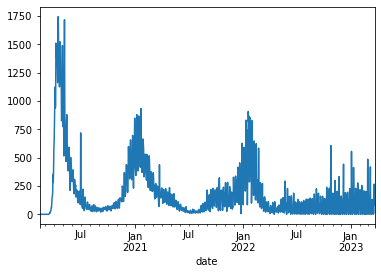

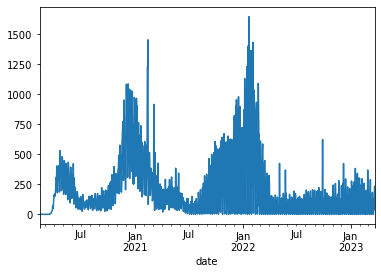

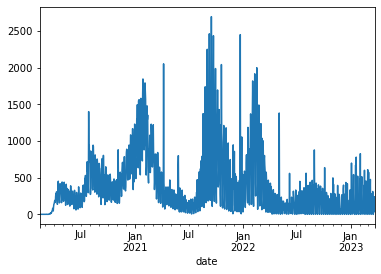

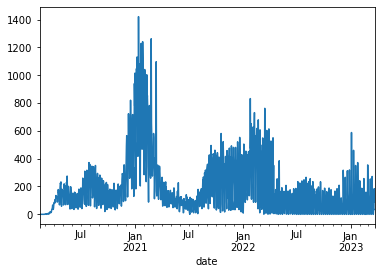

In [34]:
east['daily_deaths'].plot()
plt.show()

midwest['daily_deaths'].plot()
plt.show()

south['daily_deaths'].plot()
plt.show()

west['daily_deaths'].plot()
plt.show()

# splitting into train test
- setting a specific number for train test i.e. train is any data before 2023 and test is the last couple of months

In [6]:
# Date for splitting training and testing dataset
train_end_date = '2023-01-01'

In [7]:
easttrain = east[east.index < train_end_date]
easttest = east[east.index >= train_end_date]
print(easttrain.shape, easttest.shape)

midwesttrain = midwest[midwest.index < train_end_date]
midwesttest = midwest[midwest.index >= train_end_date]
print(midwesttrain.shape, midwesttest.shape)

southtrain = south[south.index < train_end_date]
southtest = south[south.index >= train_end_date]
print(southtrain.shape, southtest.shape)

westtrain = west[west.index < train_end_date]
westtest = west[west.index >= train_end_date]
print(westtrain.shape, westtest.shape)

(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)


# Building the prophet model

### defining an MASE function

In [8]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted[1:] - Actual[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

## east

### building a baseline model

17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing


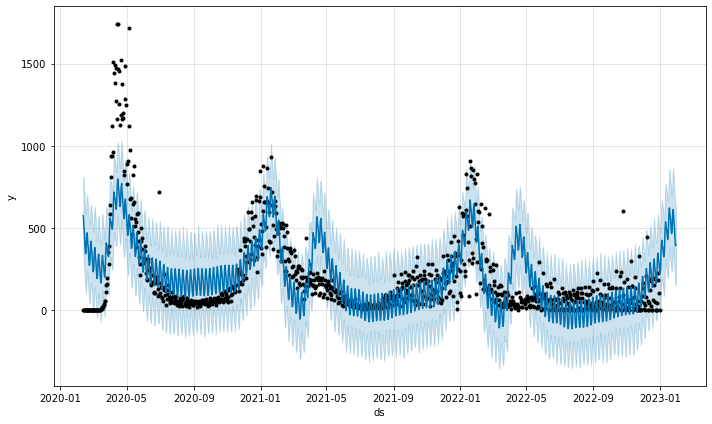

In [9]:
# Use the default hyperparameters to initiate the Prophet model
emodel_baseline = Prophet()

# Fit the model on the training dataset
emodel_baseline.fit(easttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# 30 day forecase
efuture_baseline = emodel_baseline.make_future_dataframe(periods=30)

# Make prediction
eforecast_baseline = emodel_baseline.predict(efuture_baseline)

# Visualize the forecast
emodel_baseline.plot(eforecast_baseline); # Add semi-colon to remove the duplicated chart

In [10]:
# Merge actual and predicted values
eperformance_baseline = pd.merge(easttest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}), eforecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
eperformance_baseline_MAE = mean_absolute_error(eperformance_baseline['y'], eperformance_baseline['yhat'])
print(f'The MAE for the baseline model is {eperformance_baseline_MAE}')

# Check MAPE value
eperformance_baseline_MAPE = mean_absolute_percentage_error(eperformance_baseline['y'], eperformance_baseline['yhat'])
print(f'The MAPE for the baseline model is {eperformance_baseline_MAPE}')

The MAE for the baseline model is 360.47409494307914
The MAPE for the baseline model is 3.9233905732288384e+17


### building a better model

17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing


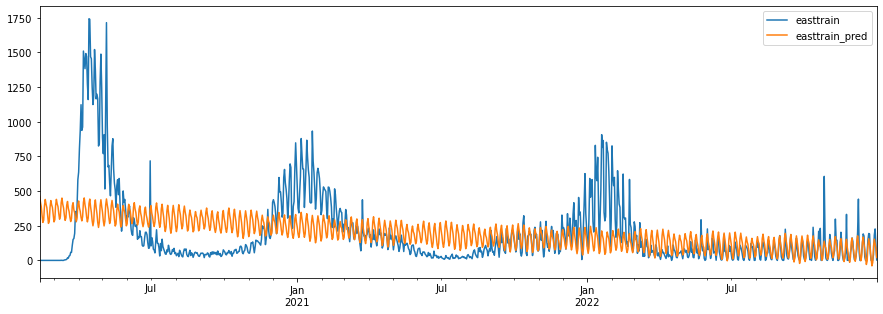

Training Set Metrics:
MAE: 155.80563184235245
MASE: 0.9594877888996809


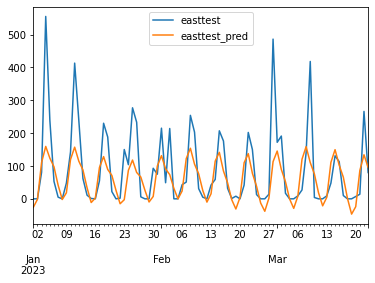

Testing Set Metrics:
MAE: 60.65951966531297
MASE: 0.7786441138994341


In [11]:
# CURRENT BEST
emodel = prophet.Prophet(
    changepoint_prior_scale=0.04, # controls flexibility of trend
    seasonality_prior_scale=7.0, # controls strength of seasonality components
    yearly_seasonality=False,  # Disable default yearly seasonality
)
emodel.add_seasonality(name='monthly', period=30.44, fourier_order=5)
emodel.add_seasonality(name='weekly', period=7, fourier_order=3)

emodel.fit(easttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# train
easttrain_pred=emodel.predict(easttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')

pd.concat([easttrain,easttrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['easttrain', 'easttrain_pred'])
plt.show()

# Calculate metrics

actual_train = easttrain['daily_deaths'].values
predicted_train = easttrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

#test

easttest_pred=emodel.predict(easttest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')

pd.concat([easttest,easttest_pred['yhat']], axis=1).plot( )
plt.legend(['easttest', 'easttest_pred'])
plt.show()

# Calculate metrics

actual_test = easttest['daily_deaths'].values
predicted_test = easttest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

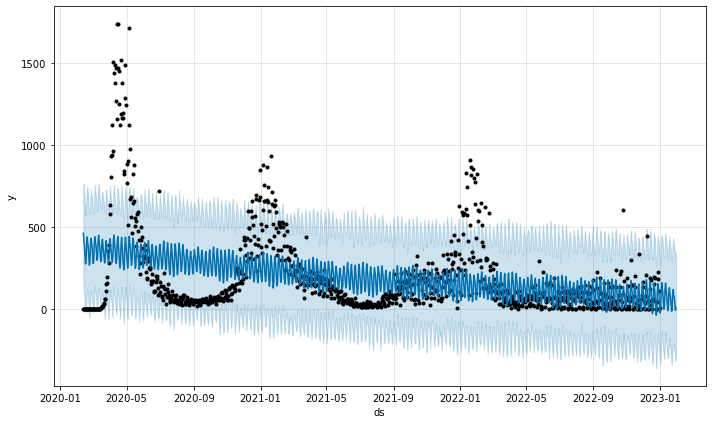

In [12]:
# Create the time range for the forecast
efuture_season = emodel.make_future_dataframe(periods=30)

# Make prediction
eforecast_season = emodel.predict(efuture_season)

# Visualize the forecast
emodel.plot(eforecast_season); # Add semi-colon to remove the duplicated chart

## midwest

### building a baseline model

17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing


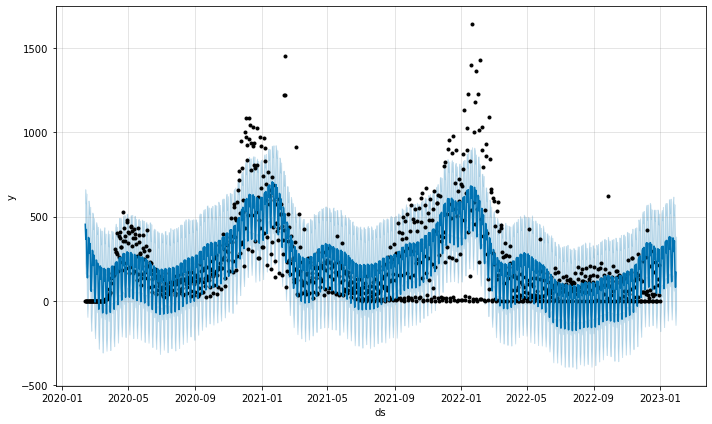

In [13]:
# Use the default hyperparameters to initiate the Prophet model
mmodel_baseline = Prophet()

# Fit the model on the training dataset
mmodel_baseline.fit(midwesttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# 30 day forecase
mfuture_baseline = mmodel_baseline.make_future_dataframe(periods=30)

# Make prediction
mforecast_baseline = mmodel_baseline.predict(mfuture_baseline)

# Visualize the forecast
mmodel_baseline.plot(mforecast_baseline); # Add semi-colon to remove the duplicated chart

In [14]:
# Merge actual and predicted values
mperformance_baseline = pd.merge(midwesttest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}), mforecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
mperformance_baseline_MAE = mean_absolute_error(mperformance_baseline['y'], mperformance_baseline['yhat'])
print(f'The MAE for the baseline model is {mperformance_baseline_MAE}')

# Check MAPE value
mperformance_baseline_MAPE = mean_absolute_percentage_error(mperformance_baseline['y'], mperformance_baseline['yhat'])
print(f'The MAPE for the baseline model is {mperformance_baseline_MAPE}')

The MAE for the baseline model is 139.15097714865098
The MAPE for the baseline model is 2.4733073450687366e+17


### building a better model

17:38:50 - cmdstanpy - INFO - Chain [1] start processing
17:38:50 - cmdstanpy - INFO - Chain [1] done processing


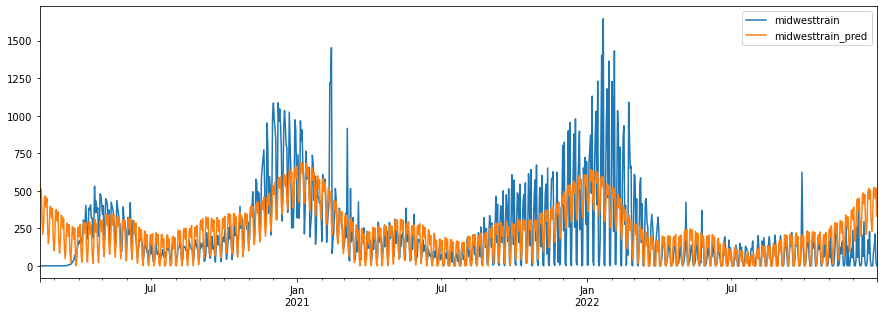

Training Set Metrics:
MAE: 122.37993250066577
MASE: 0.8101989533916135


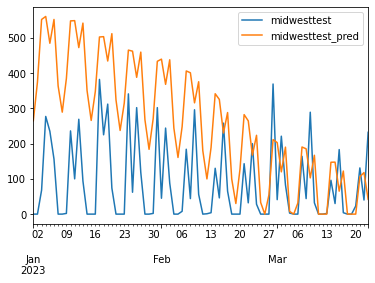

Testing Set Metrics:
MAE: 188.52228516114656
MASE: 1.0378330786931003


In [15]:
# CURRENT BEST
mmodel = prophet.Prophet(
    changepoint_prior_scale=0.006, # controls flexibility of trend
    seasonality_prior_scale=6.0, # controls strength of seasonality components
    yearly_seasonality=3,  
)
mmodel.add_seasonality(name='monthly', period=30.44, fourier_order=5)
mmodel.add_seasonality(name='weekly', period=7, fourier_order=3)

mmodel.fit(midwesttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# train
midwesttrain_pred=mmodel.predict(midwesttrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative predictions
midwesttrain_pred = np.maximum(midwesttrain_pred, 0)
pd.concat([midwesttrain,midwesttrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['midwesttrain', 'midwesttrain_pred'])
plt.show()

# Calculate metrics

actual_train = midwesttrain['daily_deaths'].values
predicted_train = midwesttrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
midwesttest_pred=mmodel.predict(midwesttest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')

#clipping negative predictions
midwesttest_pred = np.maximum(midwesttest_pred, 0)
pd.concat([midwesttest,midwesttest_pred['yhat']], axis=1).plot( )
plt.legend(['midwesttest', 'midwesttest_pred'])
plt.show()

# Calculate metrics

actual_test = midwesttest['daily_deaths'].values
predicted_test = midwesttest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

So i noticed something interesting with the Midwesttest_pred graph:

- it appears that the trends are accounted for well BUT the predictions seem almost to be shifted up vertically
- so in order to address this I shifted the train values down

logic:
- adjusted model performing better on the adjusted training set, and this improvement might carry over to some extent when tested on the unadjusted test set

17:38:59 - cmdstanpy - INFO - Chain [1] start processing
17:38:59 - cmdstanpy - INFO - Chain [1] done processing


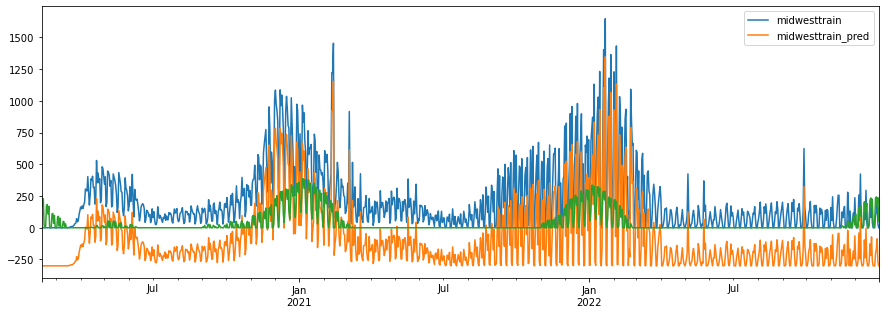

Training Set Metrics:
MAE: 209.4026429095543
MASE: 0.9646198906578477


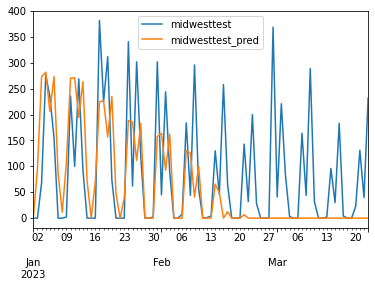

Testing Set Metrics:
MAE: 73.64788877412371
MASE: 0.9603876473589953


In [16]:
# after adjusting

# adjusted

midwesttrain['adjusted_daily_deaths'] = midwesttrain['daily_deaths'] - 300

mmodel = prophet.Prophet(
    changepoint_prior_scale=0.006, # controls flexibility of trend
    seasonality_prior_scale=6.0, # controls strength of seasonality components
    yearly_seasonality=3,  
)
mmodel.add_seasonality(name='monthly', period=30.44, fourier_order=5)
mmodel.add_seasonality(name='weekly', period=7, fourier_order=3)


mmodel.fit(midwesttrain.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'}))

#train
midwesttrain_pred=mmodel.predict(midwesttrain.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'})).set_index('ds')
#clipping negative
midwesttrain_pred = np.maximum(midwesttrain_pred, 0)
pd.concat([midwesttrain,midwesttrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['midwesttrain', 'midwesttrain_pred'])
plt.show()

# Calculate metrics

actual_train = midwesttrain['adjusted_daily_deaths'].values
predicted_train = midwesttrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
midwesttest_pred=mmodel.predict(midwesttest.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'})).set_index('ds')
#clipping negative
midwesttest_pred = np.maximum(midwesttest_pred, 0)
pd.concat([midwesttest,midwesttest_pred['yhat']], axis=1).plot( )
plt.legend(['midwesttest', 'midwesttest_pred'])
plt.show()

# Calculate metrics

actual_test = midwesttest['daily_deaths'].values
predicted_test = midwesttest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

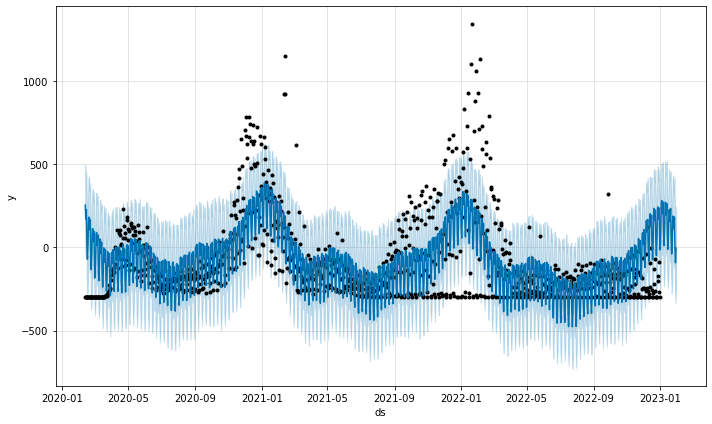

In [17]:
# Create the time range for the forecast
mfuture_season = mmodel.make_future_dataframe(periods=30)

# Make prediction
mforecast_season = mmodel.predict(mfuture_season)

# Visualize the forecast
mmodel.plot(mforecast_season); # Add semi-colon to remove the duplicated chart

## south

### building a baseline model

17:39:08 - cmdstanpy - INFO - Chain [1] start processing
17:39:08 - cmdstanpy - INFO - Chain [1] done processing


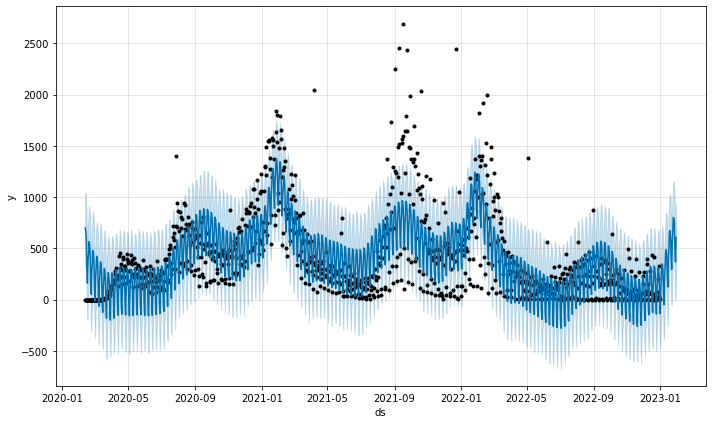

In [18]:
# Use the default hyperparameters to initiate the Prophet model
smodel_baseline = Prophet()

# Fit the model on the training dataset
smodel_baseline.fit(southtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# 30 day forecase
sfuture_baseline = smodel_baseline.make_future_dataframe(periods=30)

# Make prediction
sforecast_baseline = smodel_baseline.predict(sfuture_baseline)

# Visualize the forecast
smodel_baseline.plot(sforecast_baseline); # Add semi-colon to remove the duplicated chart

In [19]:
# Merge actual and predicted values
sperformance_baseline = pd.merge(southtest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}), sforecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
sperformance_baseline_MAE = mean_absolute_error(sperformance_baseline['y'], sperformance_baseline['yhat'])
print(f'The MAE for the baseline model is {sperformance_baseline_MAE}')

# Check MAPE value
sperformance_baseline_MAPE = mean_absolute_percentage_error(sperformance_baseline['y'], sperformance_baseline['yhat'])
print(f'The MAPE for the baseline model is {sperformance_baseline_MAPE}')

The MAE for the baseline model is 292.8736883004854
The MAPE for the baseline model is 2.136424681919862e+17


### building a better model

17:39:15 - cmdstanpy - INFO - Chain [1] start processing
17:39:15 - cmdstanpy - INFO - Chain [1] done processing


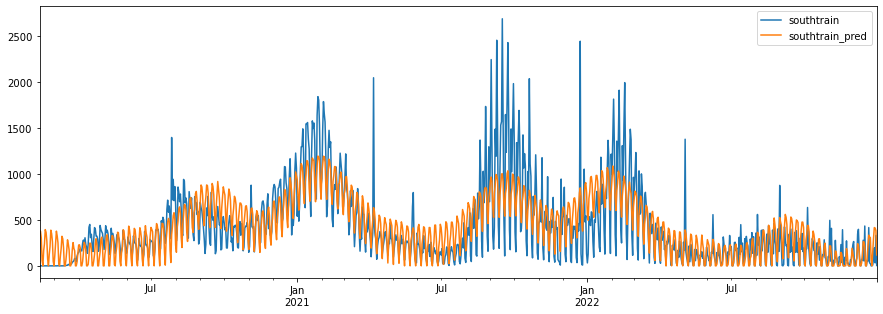

Training Set Metrics:
MAE: 185.6851719128908
MASE: 0.849570623449164


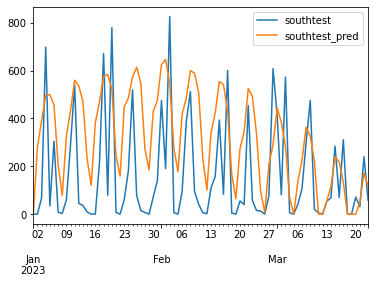

Testing Set Metrics:
MAE: 203.95475000253035
MASE: 0.8535919572827201


In [20]:
smodel = prophet.Prophet(
    changepoint_prior_scale=0.12, # controls flexibility of trend
    seasonality_prior_scale=6.0, # controls strength of seasonality components
    yearly_seasonality=3,  
)
smodel.add_seasonality(name='monthly', period=30.44, fourier_order=10)
smodel.add_seasonality(name='weekly', period=7, fourier_order=20)


smodel.fit(southtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

#train
southtrain_pred=smodel.predict(southtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative
southtrain_pred = np.maximum(southtrain_pred, 0)
pd.concat([southtrain,southtrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['southtrain', 'southtrain_pred'])
plt.show()

# Calculate metrics

actual_train = southtrain['daily_deaths'].values
predicted_train = southtrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
southtest_pred=smodel.predict(southtest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative
southtest_pred = np.maximum(southtest_pred, 0)
pd.concat([southtest,southtest_pred['yhat']], axis=1).plot( )
plt.legend(['southtest', 'southtest_pred'])
plt.show()

# Calculate metrics

actual_test = southtest['daily_deaths'].values
predicted_test = southtest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

So i noticed something interesting with the Southtest_pred graph:
- it appears that the trends are accounted for well BUT the predictions seem almost to be shifted up vertically
- so in order to address this I shifted the train values down

logic:
- adjusted model performing better on the adjusted training set, and this improvement might carry over to some extent when tested on the unadjusted test set

17:39:22 - cmdstanpy - INFO - Chain [1] start processing
17:39:22 - cmdstanpy - INFO - Chain [1] done processing


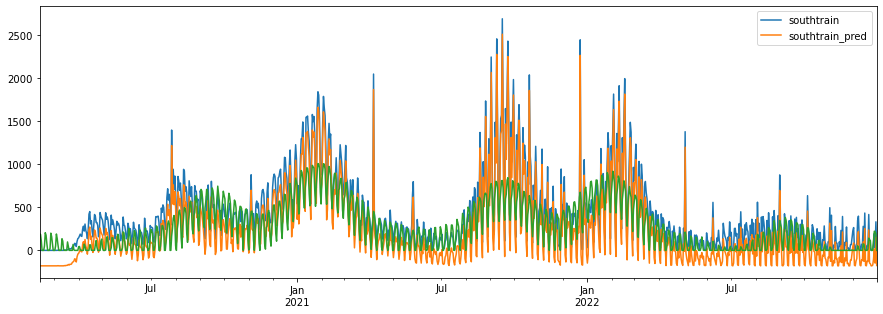

Training Set Metrics:
MAE: 197.0833677921142
MASE: 0.8899162993855364


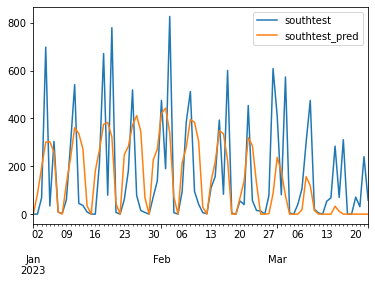

Testing Set Metrics:
MAE: 132.38862794515373
MASE: 0.8514215406759845


In [21]:
# adjusted

southtrain['adjusted_daily_deaths'] = southtrain['daily_deaths'] - 180

smodel = prophet.Prophet(
    changepoint_prior_scale=0.12, # controls flexibility of trend
    seasonality_prior_scale=6.0, # controls strength of seasonality components
    yearly_seasonality=3,  
)
smodel.add_seasonality(name='monthly', period=30.44, fourier_order=10)
smodel.add_seasonality(name='weekly', period=7, fourier_order=20)


smodel.fit(southtrain.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'}))

#train
southtrain_pred=smodel.predict(southtrain.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'})).set_index('ds')
#clipping negative
southtrain_pred = np.maximum(southtrain_pred, 0)
pd.concat([southtrain,southtrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['southtrain', 'southtrain_pred'])
plt.show()

# Calculate metrics

actual_train = southtrain['adjusted_daily_deaths'].values
predicted_train = southtrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
southtest_pred=smodel.predict(southtest.reset_index().rename(columns={'date':'ds', 'adjusted_daily_deaths':'y'})).set_index('ds')
#clipping negative
southtest_pred = np.maximum(southtest_pred, 0)
pd.concat([southtest,southtest_pred['yhat']], axis=1).plot( )
plt.legend(['southtest', 'southtest_pred'])
plt.show()

# Calculate metrics

actual_test = southtest['daily_deaths'].values
predicted_test = southtest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

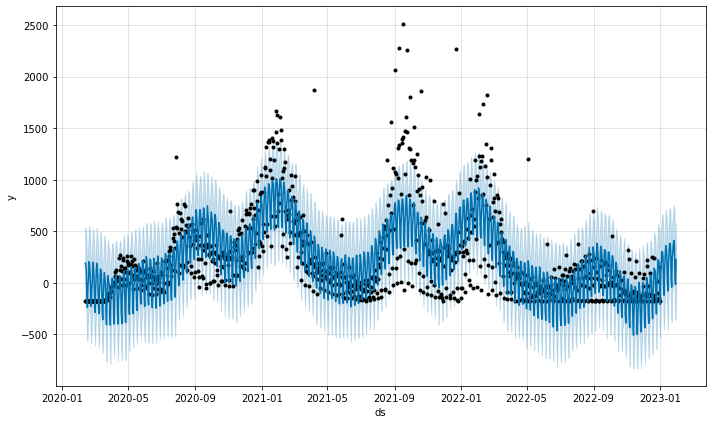

In [22]:
# Create the time range for the forecast
sfuture_season = smodel.make_future_dataframe(periods=30)

# Make prediction
sforecast_season = smodel.predict(sfuture_season)

# Visualize the forecast
smodel.plot(sforecast_season); # Add semi-colon to remove the duplicated chart

## west

### building a baseline model

17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing


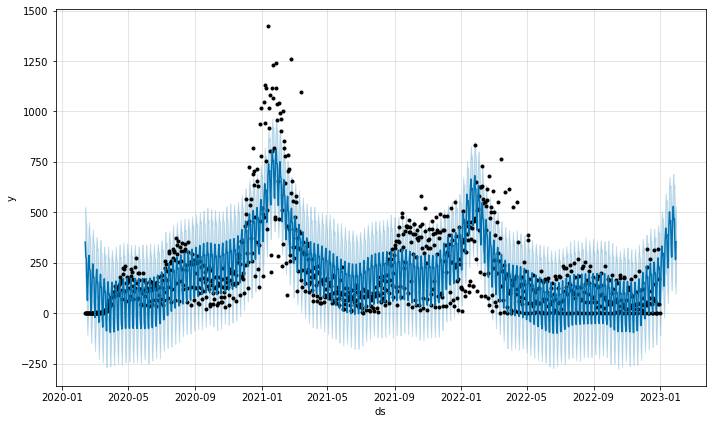

In [23]:
# Use the default hyperparameters to initiate the Prophet model
wmodel_baseline = Prophet()

# Fit the model on the training dataset
wmodel_baseline.fit(westtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# 30 day forecase
wfuture_baseline = wmodel_baseline.make_future_dataframe(periods=30)

# Make prediction
wforecast_baseline = wmodel_baseline.predict(wfuture_baseline)

# Visualize the forecast
wmodel_baseline.plot(wforecast_baseline); # Add semi-colon to remove the duplicated chart

In [24]:
# Merge actual and predicted values
wperformance_baseline = pd.merge(westtest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}), wforecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
wperformance_baseline_MAE = mean_absolute_error(wperformance_baseline['y'], wperformance_baseline['yhat'])
print(f'The MAE for the baseline model is {wperformance_baseline_MAE}')

# Check MAPE value
wperformance_baseline_MAPE = mean_absolute_percentage_error(wperformance_baseline['y'], wperformance_baseline['yhat'])
print(f'The MAPE for the baseline model is {wperformance_baseline_MAPE}')

The MAE for the baseline model is 250.1380373139762
The MAPE for the baseline model is 2.985013937153042e+17


### building a better model

17:39:38 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing


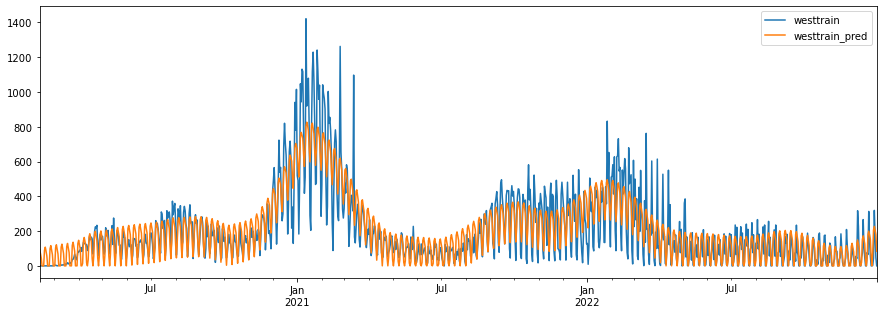

Training Set Metrics:
MAE: 74.4533690756697
MASE: 0.7699522095756957


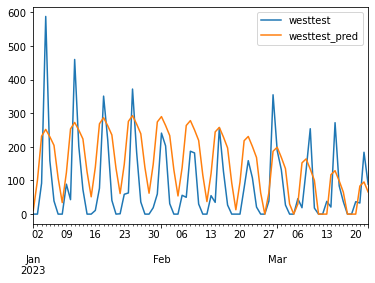

Testing Set Metrics:
MAE: 93.27287389163756
MASE: 0.93348066099597


In [25]:
# CURRENT BEST
wmodel = prophet.Prophet(
    changepoint_prior_scale=0.21, # controls flexibility of trend
    seasonality_prior_scale=10.0, # controls strength of seasonality components
    yearly_seasonality=3,
)
#wmodel.add_seasonality(name='monthly', period=30.44, fourier_order=2)
wmodel.add_seasonality(name='weekly', period=7, fourier_order=2)

wmodel.fit(westtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'}))

# train
westtrain_pred=wmodel.predict(westtrain.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative
westtrain_pred = np.maximum(westtrain_pred, 0)
pd.concat([westtrain,westtrain_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['westtrain', 'westtrain_pred'])
plt.show()

# Calculate metrics

actual_train = westtrain['daily_deaths'].values
predicted_train = westtrain_pred['yhat'].values

mae_train = mean_absolute_error(actual_train, predicted_train)
mase_train = MASE(actual_train, predicted_train)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
westtest_pred=wmodel.predict(westtest.reset_index().rename(columns={'date':'ds', 'daily_deaths':'y'})).set_index('ds')
#clipping negative
westtest_pred = np.maximum(westtest_pred, 0)
pd.concat([westtest,westtest_pred['yhat']], axis=1).plot( )
plt.legend(['westtest', 'westtest_pred'])
plt.show()

# Calculate metrics

actual_test = westtest['daily_deaths'].values
predicted_test = westtest_pred['yhat'].values

mae_test = mean_absolute_error(actual_test, predicted_test)
mase_test = MASE(actual_test, predicted_test)
print("Testing Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

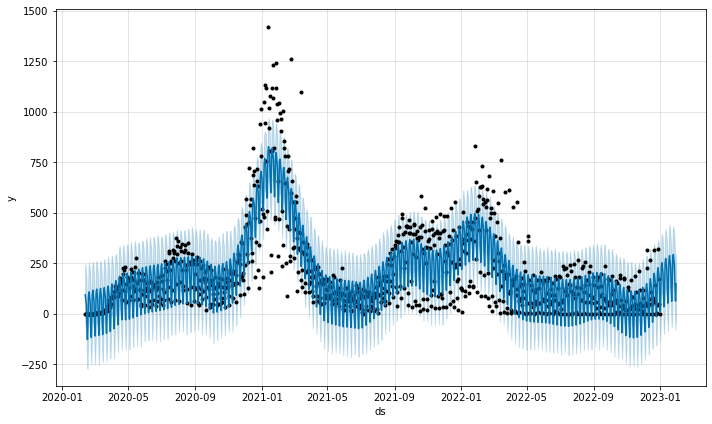

In [26]:
# Create the time range for the forecast
wfuture_season = wmodel.make_future_dataframe(periods=30)

# Make prediction
wforecast_season = wmodel.predict(wfuture_season)

# Visualize the forecast
wmodel.plot(wforecast_season); # Add semi-colon to remove the duplicated chart